In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, CategoryEncoding, Input
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model
import keras
from keras import backend as K
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
import pandas as pd

In [2]:
# OPTIONAL: limit NVRAM Usage on GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


In [3]:
# Initialise directories
data_dir = 'data'
image_exts = ['jpeg', 'jpg']

In [ ]:
# Remove corrupt images

for image_class in os.listdir(data_dir):
    
    try:

        for image in os.listdir(os.path.join(data_dir, image_class)):
            
            image_path = os.path.join(data_dir, image_class, image)

            try:
                img = cv2.imread(image_path)
                tip = imghdr.what(image_path)

                if tip not in image_exts:
                    print(f'Image not in ext list {image_path}')
                    os.remove(image_path)

            except Exception as e:
                print(f'Issue with image {image_path}')
                os.remove(image_path)

    except NotADirectoryError:              # Checks wheter dir or .DS_Store
        pass

In [ ]:
#tf.keras.utils.image_dataset_from_directory??

In [4]:
# Load data
data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(480, 640), label_mode='categorical')

Found 27805 files belonging to 2 classes.
Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



In [ ]:
data

In [5]:
# Inspect data

# Convert data into numpy iterator
data_iterator = data.as_numpy_iterator()

# Convert into batch
batch = data_iterator.next()

# Image 0 represented as numpy array
batch[0].shape

2023-05-03 20:45:22.120772: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(32, 480, 640, 3)

In [ ]:
y = []
for batch in data.as_numpy_iterator():
    
    y += [batch[1]]


display(y)

In [ ]:
def get_counts(y):
    r = {0:0, 1:0}
    for a in y:
        unique, counts = np.unique(a,return_counts=True)
        d = dict(zip(unique, counts))
        for key in d.keys():
            r[key] += d[key]
    return r


In [ ]:
y = []
for batch in data.as_numpy_iterator():
    print(batch[1])
    y += [batch[1]]


display(get_counts(y))


In [ ]:
489/1623

In [ ]:
451/1661

In [ ]:
1429/4939

In [ ]:
batch[0][:1]

In [ ]:
# Get another batch from iterator
batch = data_iterator.next()

n = 10
# Check integer assigned to class
fig, ax = plt.subplots(ncols=n, figsize=(20,20))

for idx, img in enumerate(batch[0][:n]):
    ax[idx].imshow(img.astype(int))
    l = "particle drag"
    if batch[1][idx][1] == 1:
        l = "ok"
    ax[idx].title.set_text(l)


In [ ]:
# Preprocess data

# Different options in documentation
# tf.data.Dataset
# .map allows accesing items in pipeline

# Scale data
#data = data.map(lambda x, y: (x/479, y))

# TODO check me l8r

In [ ]:
# Number of batches
len(data)

In [6]:
# Split data
train_size = int(len(data) * 0.6)
test_size = int(len(data) * 0.2)
val_size = int(len(data) * 0.2) 

In [7]:
val_size + train_size + test_size

867

In [ ]:
val_size

In [ ]:
test_size

In [ ]:
train_size

In [8]:
# Allocate training/validating/testing sizes
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [ ]:
# Model architecture for testing
model = Sequential()

model.add(Conv2D(64, (3,3), 1, activation='relu', input_shape=(480, 640, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(256, (3,3), 1, activation='relu'))
model.add(Conv2D(256, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(512, (3,3), 1, activation='relu'))
model.add(Conv2D(512, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='softmax'))           # mapping to 0 or 1

model.summary()

In [9]:
# Model architecture
model = Sequential()

model.add(Conv2D(32, (3,3), 1, activation='relu',input_shape=(480, 640, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))           # mapping to 0 or 1

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 478, 638, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 239, 319, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 237, 317, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 118, 158, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 116, 156, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 58, 78, 64)       0

In [10]:
# Compile model
optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer, loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

/Users/timmoachsel/miniforge3/envs/tf1/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
# Train the model
logdir = 'logs'

# Callback to save tensorboard log to logdir
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [12]:
# Training using model.fit
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
521/521 [==============================] - 143s 273ms/step - loss: 4.7563 - accuracy: 0.8691 - val_loss: 0.2350 - val_accuracy: 0.8831
Epoch 2/20
521/521 [==============================] - 143s 273ms/step - loss: 0.2316 - accuracy: 0.8924 - val_loss: 0.2238 - val_accuracy: 0.8945
Epoch 3/20
521/521 [==============================] - 144s 275ms/step - loss: 0.1989 - accuracy: 0.9113 - val_loss: 0.1887 - val_accuracy: 0.9221
Epoch 4/20
521/521 [==============================] - 144s 275ms/step - loss: 0.1691 - accuracy: 0.9296 - val_loss: 0.1757 - val_accuracy: 0.9261
Epoch 5/20
521/521 [==============================] - 143s 274ms/step - loss: 0.1319 - accuracy: 0.9434 - val_loss: 0.1423 - val_accuracy: 0.9418
Epoch 6/20
521/521 [==============================] - 143s 275ms/step - loss: 0.1142 - accuracy: 0.9519 - val_loss: 0.1051 - val_accuracy: 0.9594
Epoch 7/20
521/521 [==============================] - 143s 275ms/step - loss: 0.0811 - accuracy: 0.9671 - val_loss: 0.0904 -

In [ ]:
# TODO check predictions

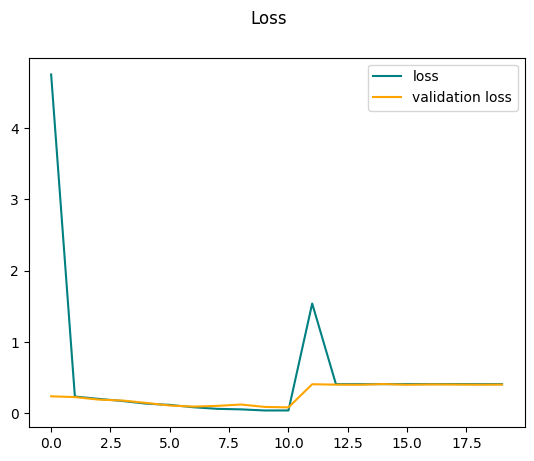

In [13]:
# Plot performance
# hist.history

fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='validation loss')
fig.suptitle('Loss')
plt.legend(loc='upper right')
plt.show()

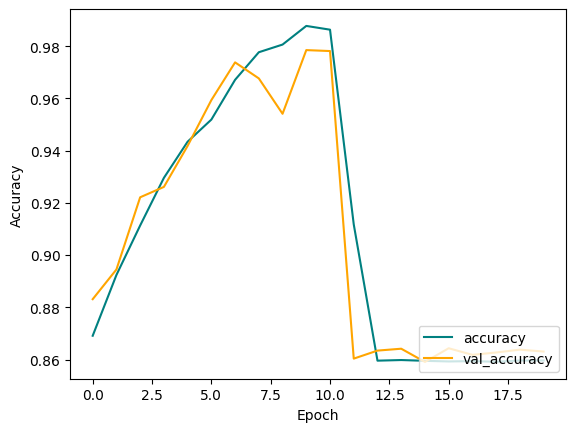

In [14]:
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [16]:
# Evaluate model performance
precision = Precision()
recall = Recall()
bin_acc = BinaryAccuracy()

In [ ]:
figs = 0
for batch in test.as_numpy_iterator():
    figs += 1
    # Check integer assigned to class

    X, y = batch

    yhat = model.predict(X)

    n = 10
    fig, ax = plt.subplots(ncols=n, figsize=(20,20))


    for idx, img in enumerate(batch[0][:n]):
        ax[idx].imshow(img.astype(int))
        pred = np.around(np.array(yhat[idx]),2)
        l = "particle drag"
        if batch[1][idx][1] > 0:
            l = "ok"
        ax[idx].title.set_text(l)

    if figs > 5:
        break
    
    

    

In [17]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    bin_acc.update_state(y, yhat)

1/1 [==============================] - 0s 30ms/step


In [18]:
print(f'(Precision = {precision.result()}\tRecall = {recall.result()}\tBinary Accuracy = {bin_acc.result()})')

(Precision = 0.865606963634491	Recall = 0.865606963634491	Binary Accuracy = 0.865606963634491)


In [ ]:
# Save the model
model.save(os.path.join('models', 'particledrag_dataset=230503_epochs=15.h5'))     # enter name of model